In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import re

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify which cell to load, which variable to plot (place/headdirection/spatialview)
cell_name = '20181101/a1/ch19/c2'
folder = '50ms_10fold(23-09-18)'
var_type = 'place'

In [3]:
def parse_cell_id(cell_id: str) -> list:
    # format:
    # fields[0] - date in YYYYMMDD
    # fields[1] - array no.
    # fields[2] - channel no.
    # fields[3] - cell no.
    return re.sub(r'(\d{8})/a(\d)/ch(\d{2,3})/c(\d)', lambda x: f'{x.group(1)}/array{x.group(2).zfill(2)}/channel{x.group(3).zfill(3)}/cell{x.group(4).zfill(2)}', cell_id).split('/')

vmobj_filenames = {'place': 'vmpc', 'headdirection': 'vmhd', 'spatialview': 'vmsv'}
vmobj_varnames = {'place': 'vmp', 'headdirection': 'vmd', 'spatialview': 'vms'}

cell_id = parse_cell_id(cell_name)
data_file = f'/Users/jcheng/Documents/Data/{cell_id[0]}/session01/{cell_id[1]}/{cell_id[2]}/{cell_id[3]}/{folder}/vmpvData.mat'
vmobj_file = f'/Users/jcheng/Documents/Data/{cell_id[0]}/session01/{cell_id[1]}/{cell_id[2]}/{cell_id[3]}/{vmobj_filenames[var_type]}.mat'
res_file = f'/Users/jcheng/Documents/Data/{cell_id[0]}/session01/{cell_id[1]}/{cell_id[2]}/{cell_id[3]}/{folder}/glm_hardcastle_results.mat'

# Load in vmpvData.mat file
vmpv_data = h5py.File(data_file).get('vmpvData')
bin_stc = np.array(vmpv_data.get('bin_stc')).T
tbin_size = vmpv_data.get('tbin_size')[0,0]
place_good_bins = np.array(vmpv_data.get('place_good_bins'), dtype=int).flatten()-1
view_good_bins = np.array(vmpv_data.get('view_good_bins'), dtype=int).flatten()-1

# Load in vmobj.mat file
vmobj_data = h5py.File(vmobj_file).get(vmobj_varnames[var_type]).get('data')
adsm_map = np.array(vmobj_data.get('maps_adsm'))

# Load in glm_hardcastle_results.mat file
hc_results = h5py.File(res_file).get('hc_results')
num_folds = int(hc_results.get('num_folds')[0,0])
model_class = int(np.nan_to_num(hc_results.get('classification')[0,0]))
params_consol = hc_results.get('params_consol')
similarity_scores = hc_results.get('similarity_scores')[0]
model_params = list()
for i in range(params_consol.shape[0]):
    row = list()
    for j in range(params_consol.shape[1]):
        row.append(np.array(hc_results[params_consol[i,j]]).flatten())
    model_params.append(row)
model_scores = list()
for i in range(similarity_scores.shape[0]):
    model_scores.append(np.array(hc_results[similarity_scores[i]]))

In [4]:
### vmpv_data processing ###
num_place, num_hd, num_view = 1600, 60, 5122
if var_type == 'place':
    num_params = num_place
    pcol = 1
    bin_nums_good = place_good_bins
elif var_type == 'headdirection':
    num_params = num_hd
    pcol = 2
    bin_nums_good = np.arange(num_params)
elif var_type == 'spatialview':
    num_params = num_view
    pcol = 3
    bin_nums_good = view_good_bins

# Generate distribution of spike counts per observation for each bin
fc_map = [list() for _ in range(num_params)]
for row in range(bin_stc.shape[0]):
    bin_num = int(bin_stc[row, pcol])-1
    fc_map[bin_num].append(bin_stc[row, 4])
fc_map = list(map(np.array, fc_map))

# Generate firing rate maps per bin
fr_map = np.array(list(map(lambda arr: np.sum(arr)/(tbin_size*arr.shape[0]), fc_map)))

# Filter out unoccupied bins
fc_map_filtered = [fc_map[i] for i in range(len(fc_map)) if fc_map[i].shape[0] > 0]
fr_map_filtered = [fr_map[i] for i in range(len(fr_map)) if fc_map[i].shape[0] > 0]

# Generate firing rate maps per bin, using training data from each fold
fold_edges = np.round(np.linspace(0, bin_stc.shape[0], (5*num_folds)+1))
fr_map_folds = list()
for k in range(num_folds):
    # Generate training datapoints used for each fold
    test_ind  = np.hstack([np.arange(fold_edges[k], fold_edges[k+1]), np.arange(fold_edges[k+num_folds], fold_edges[k+num_folds+1]), np.arange(fold_edges[k+2*num_folds], fold_edges[k+2*num_folds+1]),\
                 np.arange(fold_edges[k+3*num_folds], fold_edges[k+3*num_folds+1]), np.arange(fold_edges[k+4*num_folds], fold_edges[k+4*num_folds+1])])
    train_ind = np.setdiff1d(np.arange(bin_stc.shape[0]), test_ind)
    bin_stc_fold = bin_stc[train_ind,:]
    # Generate distribution of spike counts per observation for each bin
    fc_map_fold = [list() for _ in range(num_params)]
    for row in range(bin_stc_fold.shape[0]):
        bin_num = int(bin_stc_fold[row, pcol])-1
        fc_map_fold[bin_num].append(bin_stc_fold[row, 4])
    fc_map_fold = list(map(np.array, fc_map_fold))
    # Generate firing rate maps per bin
    fr_map_fold = np.array(list(map(lambda arr: np.sum(arr)/(tbin_size*arr.shape[0]), fc_map_fold)))
    fr_map_folds.append(fr_map_fold)
fr_map_folds = np.array(fr_map_folds).T
fr_map_folds_filtered = fr_map_folds[bin_nums_good,:]


### vmobj processing ###
# Filter out nan values in ratemap
adsm_map_filtered = adsm_map[bin_nums_good].flatten()


### hc_results processing ###
# Extract model-fitted parameters based on classification
if model_class == 1:  # phv
    place_params = np.array(model_params[0])[:,:num_place].T
    hd_params = np.array(model_params[0])[:,num_place:num_place+num_hd].T
    view_params = np.array(model_params[0])[:,num_place+num_hd:].T

    place_scores = model_scores[0][0,:]
    hd_scores = model_scores[0][1,:]
    view_scores = model_scores[0][2,:]

elif model_class == 2:  # ph
    place_params = np.array(model_params[1])[:,:num_place].T
    hd_params = np.array(model_params[1])[:,num_place:].T
    view_params = np.array(model_params[6]).T

    place_scores = model_scores[1][0,:]
    hd_scores = model_scores[1][1,:]
    view_scores = model_scores[6].flatten()

elif model_class == 3:  # pv
    place_params = np.array(model_params[2])[:,:num_place].T
    hd_params = np.array(model_params[5]).T
    view_params = np.array(model_params[2])[:,num_place:].T

    place_scores = model_scores[2][0,:]
    hd_scores = model_scores[5].flatten()
    view_scores = model_scores[2][1,:]

elif model_class == 4:  # hv
    place_params = np.array(model_params[4]).T
    hd_params = np.array(model_params[3])[:,:num_hd].T
    view_params = np.array(model_params[3])[:,num_hd:].T

    place_scores = model_scores[4].flatten()
    hd_scores = model_scores[3][0,:]
    view_scores = model_scores[3][1,:]

else:  # single-variable models or unclassified
    place_params = np.array(model_params[4]).T
    hd_params = np.array(model_params[5]).T
    view_params = np.array(model_params[6]).T

    place_scores = model_scores[4].flatten()
    hd_scores = model_scores[5].flatten()
    view_scores = model_scores[6].flatten()

# Get firing rate map from model-fitted parameters
if var_type == 'place':
    model_params = place_params
    model_scores = place_scores
elif var_type == 'headdirection':
    model_params = hd_params
    model_scores = hd_scores
elif var_type == 'spatialview':
    model_params = view_params
    model_scores = view_scores

# Filter out unoccupied bins for plotting
fr_model = np.exp(model_params)/tbin_size
fr_model_filtered = fr_model[bin_nums_good]

# Compute ratemap fits using cosine similarity between model fit and fold data
cosine_similarity = lambda arr1, arr2: np.nansum(np.multiply(arr1, arr2)) / (np.sqrt(np.nansum(np.multiply(arr1, arr1))) * np.sqrt(np.nansum(np.multiply(arr2, arr2))))
ratemap_fits = [cosine_similarity(fr_model[:,i], fr_map_folds[:,i]) for i in range(num_folds)]

In [13]:
# Sanity check
ratemap_fits_filtered = [cosine_similarity(fr_model_filtered[:,i], fr_map_folds_filtered[:,i]) for i in range(num_folds)]
np.allclose(ratemap_fits, ratemap_fits_filtered, 0.00001)

True

Text(0, 0.5, 'Spike counts')

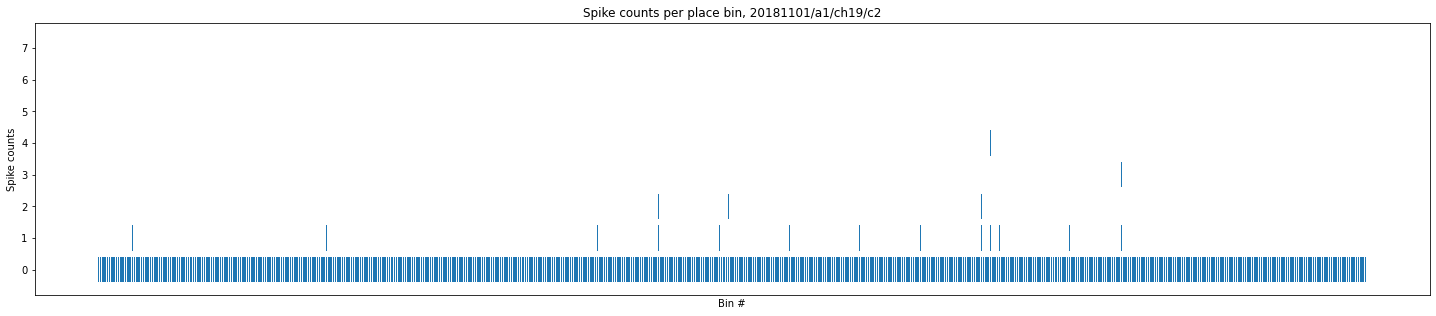

In [5]:
# Plot distribution of spike counts per bin as series of histograms
hist_data = [np.histogram(data, bins=int(max(data)-min(data)+1))[0] for data in fc_map_filtered]
hist_ranges = [np.arange(int(min(data)), int(max(data))+1) for data in fc_map_filtered]

plt.figure(figsize=(25, 5))
plt.title(f'Spike counts per {var_type} bin, {cell_name}')
# plt.xticks(np.arange(len(fc_map_filtered)), labels=bin_nums_filtered)
plt.xticks([])
for i in range(len(hist_data)):
    plt.barh(hist_ranges[i], hist_data[i]/(3*max(hist_data[i])), left=i+1, color='C0')
    plt.barh(hist_ranges[i], -hist_data[i]/(3*max(hist_data[i])), left=i+1, color='C0')
plt.xlabel('Bin #')
plt.ylabel('Spike counts')

Text(0, 0.5, 'Firing rate (Hz)')

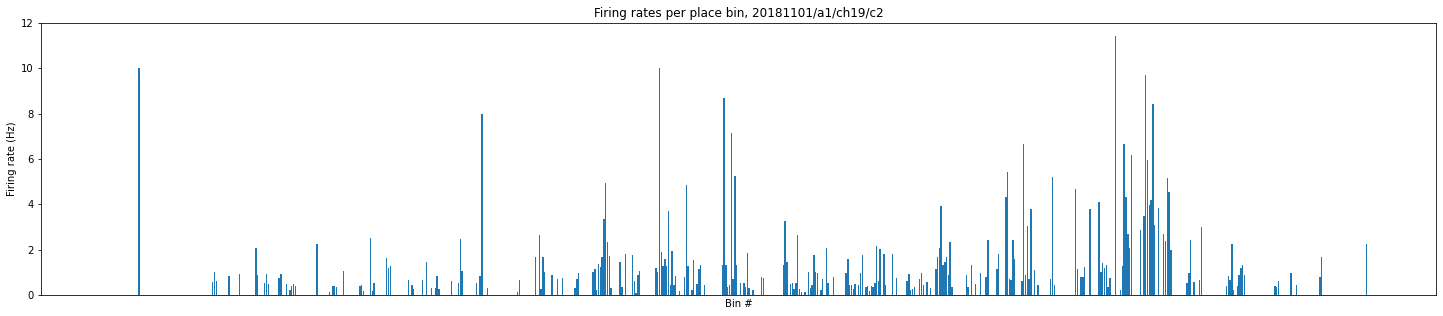

In [6]:
# Plot firing rates per bin as line plot
plt.figure(figsize=(25, 5))
plt.title(f'Firing rates per {var_type} bin, {cell_name}')
plt.bar(np.arange(len(fr_map_filtered)), fr_map_filtered)
# plt.xticks(np.arange(len(fr_map_filtered)), labels=bin_nums_filtered)
plt.xticks([])
plt.xlabel('Bin #')
plt.ylabel('Firing rate (Hz)')

Text(0.5, 1.0, 'Spike counts/firing rates per place bin, 20181101/a1/ch19/c2')

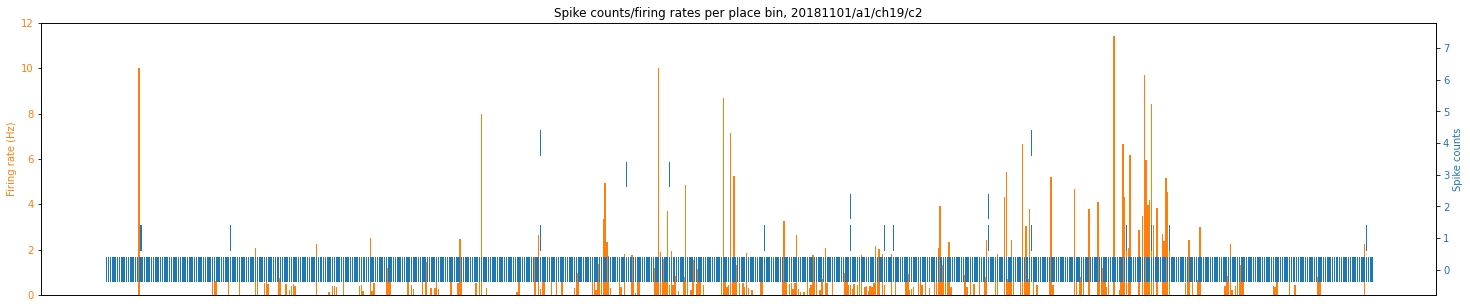

In [7]:
# Plot both spike count distribution and firing rates together
fig, ax2 = plt.subplots(figsize=(25, 5))
fig.patch.set_facecolor('white')

ax1 = ax2.twinx()
for i in range(len(hist_data)):
    ax1.barh(hist_ranges[i], hist_data[i]/(3*max(hist_data[i])), left=i+1, color='C0')
    ax1.barh(hist_ranges[i], -hist_data[i]/(3*max(hist_data[i])), left=i+1, color='C0')
ax1.set_xlabel('Bin #')
ax1.set_xticks([])
ax1.set_ylabel('Spike counts', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2.bar(np.arange(len(fr_map_filtered)), fr_map_filtered, color='C1')
ax2.set_ylabel('Firing rate (Hz)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

plt.title(f'Spike counts/firing rates per {var_type} bin, {cell_name}')

Text(0.5, 0.905, 'Firing rate maps for place, 20181101/a1/ch19/c2')

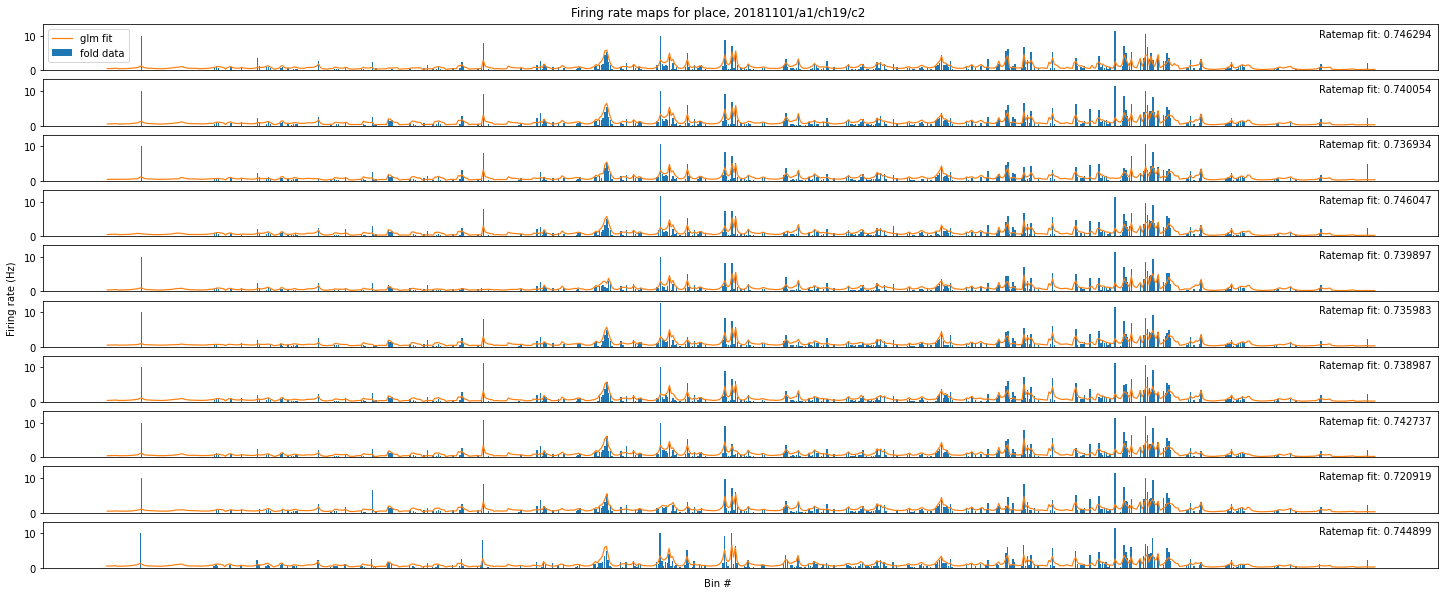

In [8]:
# Plot vmobj adsmoothed ratemap and model-fitted ratemap together
fig, axes = plt.subplots(num_folds, 1, figsize=(25, 10), sharey=True)
if var_type == 'place':
    line_width = 1.2
elif var_type == 'spatialview':
    line_width = 0.8
else:
    line_width = 1
for i in range(num_folds):
    ax = axes[i]
    ax.plot(np.arange(fr_model_filtered.shape[0]), fr_model_filtered[:,i], label='glm fit', color='C1', linewidth=line_width)
    ax.bar(np.arange(fr_map_folds_filtered.shape[0]), fr_map_folds_filtered[:,i], label='fold data', color='C0')
    ax.text(0.995, 0.9, f'Ratemap fit: {ratemap_fits[i]:.6f}', transform=ax.transAxes, ha='right', va='top')
    ax.set_xticks([])
    #ax.set_ylim(0, 8)
    
axes[0].legend(loc='upper left')
fig.text(0.5, 0.1, 'Bin #', ha='center')
fig.text(0.105, 0.5, 'Firing rate (Hz)', va='center', rotation='vertical')
fig.suptitle(f'Firing rate maps for {var_type}, {cell_name}', y=0.905)

Text(0.5, 0.905, 'Firing rate maps for place, 20181101/a1/ch19/c2')

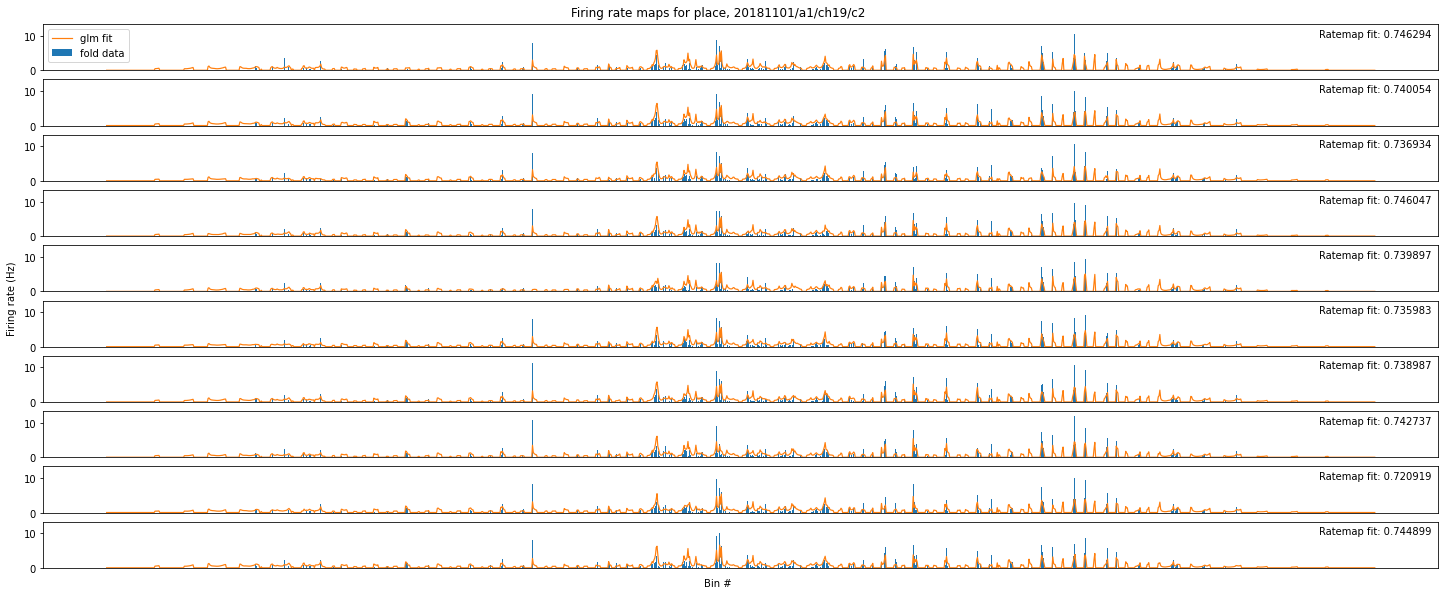

In [9]:
# Plot vmobj adsmoothed ratemap and model-fitted ratemap together
fig, axes = plt.subplots(num_folds, 1, figsize=(25, 10), sharey=True)
if var_type == 'place':
    line_width = 1.2
elif var_type == 'spatialview':
    line_width = 0.8
else:
    line_width = 1
for i in range(num_folds):
    ax = axes[i]
    ax.plot(np.arange(fr_model.shape[0]), fr_model[:,i], label='glm fit', color='C1', linewidth=line_width)
    ax.bar(np.arange(fr_map_folds.shape[0]), fr_map_folds[:,i], label='fold data', color='C0')
    ax.text(0.995, 0.9, f'Ratemap fit: {ratemap_fits[i]:.6f}', transform=ax.transAxes, ha='right', va='top')
    ax.set_xticks([])
    #ax.set_ylim(0, 8)
    
axes[0].legend(loc='upper left')
fig.text(0.5, 0.1, 'Bin #', ha='center')
fig.text(0.105, 0.5, 'Firing rate (Hz)', va='center', rotation='vertical')
fig.suptitle(f'Firing rate maps for {var_type}, {cell_name}', y=0.905)